# 프로젝트 : 다양한 OCR모델 비교하기

우리는 지금까지 Google OCR API, keras-ocr, Tesseract 이상 3가지의 OCR 기능을 간단히 활용하여 보았습니다.

지금까지 살펴본 바로는 무료로 사용할 수 있는 기능들이지만 모두 준수한 성능을 갖추고 있었습니다. OCR 분야가 이미 실용적인 수준에까지 기술이 발전했기 때문에 이런 것들만 잘 활용해도 실전에 활용할 수 있는 좋은 서비스를 만들어 낼 수 있을 것도 같습니다. 그런데 과연 어떤 것을 사용하는 것이 좋을까요?

OCR 기술들이 실용적인 수준까지 꽤 발전했지만 그럼에도 불구하고 아직 완전한 수준은 아닙니다. 용도에 맞게 적절한 것을 선택하는 것도 중요한 일입니다. 그래서 오늘 다뤄본 위 3가지를 검증해 보는 프로젝트를 진행하겠습니다. 여러분은 OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어가 되어, 어떤 모듈을 도입하면 좋을지 기술검증을 하는 역할을 맡게 되었다고 가정합니다.

### OCR 활용 서비스

- 서비스명 : 상품등록 일일이 하지 마세요. 귀찮으니까요.
- 내용
    - 요즘 같은 시대, 부업은 해야겠고, 일하느라 바쁘고, 온라인 스토어를 편하게 운영하세요
    - 제품 사진 만으로 상품 등록에 필요한 정보들을 추출할 수 있습니다
- 평가 기준
    - 여러 가지 제품 사진에서도 글자를 비교적 정확하게 인식할 수 있는가?

### Step1. 검증용 데이터셋 준비
---
OCR 관련해서 오늘 다루어본 주제는 텍스트의 모양과 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미치는 요인들에 관한 것이었습니다. 여러분들은 위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 이미지 데이터를 모아야 합니다. 이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요합니다.

가능하다면 함께 학습하는 동료들과 힘을 합쳐보는 것을 추천합니다. 그렇다고 너무 많은 이미지 데이터로 검증하는 것은 이후 결과를 정리하는 것이 힘들 수 있으니 테스트용 이미지는 아무리 많아도 20장을 넘기지 않는 것으로 합시다.

### Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행
---
위 3가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보셨을 것입니다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다.

### Step3. 테스트 결과 정리
---
모듈들마다 출력 형태가 다릅니다. 분석을 위해 결과를 일목요연하게 정리해 보는 것이 도움이 될 것입니다. 시각화 방법이 함께 활용된다면 더욱 좋겠군요.

### Step4. 결과 분석과 결론 제시
---
우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다.
여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시합니다.
그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.

## 목차
[Step1. 검증용 데이터셋 준비](#Step1.-검증용-데이터셋-준비)   
[Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행](#Step2.-Google-OCR-API,-keras-ocr,-Tesseract로-테스트-진행)  
[Step3. 테스트 결과 정리](#Step3.-테스트-결과-정리)  
[Step4. 결과 분석과 결론 제시](#Step4.-결과-분석과-결론-제시)  
[Rubric](#Rubric)  
[회고](#회고)

## Step1. 검증용 데이터셋 준비

In [1]:
import os
import io
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import keras_ocr
import pytesseract
from pytesseract import Output
from google.cloud import vision

In [2]:
img_dir = os.getenv('HOME')+'/aiffel/ocr_python/product'
file_list = os.listdir(img_dir)
file_list

['fruits.jpg',
 'soup02.jpg',
 'nuts.jpg',
 'cereal.jpg',
 'hashbrown.jpg',
 'oats.jpg',
 'soup01.jpg',
 'coffee.jpg',
 'toothpaste.jpg',
 'pancake.jpg']

## Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

### 1) Google OCR API

In [3]:
def detect_text(path):
    """Detects text in the file."""
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [4]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
#!ls -l $GOOGLE_APPLICATION_CREDENTIALS
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for file in file_list:
    print(f'[{file}]')
    detect_text(os.path.join(img_dir, file))
    print()

[fruits.jpg]
Texts:

".. Pa n
CUP S
che rry
mix ed f ruit
100 % fr uit j uice
Live Well
12-4 OZ . CUPS NET WTr 48 OZ. (3 LBS) 1.36kg
12
Drle
cherry
mixed fruit
in 100% fruit juice
NON
GMO**
**no genetically modified
(or engineered) ingredients
12 - 4 oz CUPS
"

".."

"Pa"

"n"

"CUP"

"S"

"che"

"rry"

"mix"

"ed"

"f"

"ruit"

"100"

"%"

"fr"

"uit"

"j"

"uice"

"Live"

"Well"

"12-4"

"OZ"

"."

"CUPS"

"NET"

"WTr"

"48"

"OZ."

"(3"

"LBS)"

"1.36kg"

"12"

"Drle"

"cherry"

"mixed"

"fruit"

"in"

"100%"

"fruit"

"juice"

"NON"

"GMO**"

"**no"

"genetically"

"modified"

"(or"

"engineered)"

"ingredients"

"12"

"-"

"4"

"oz"

"CUPS"
bounds: (677,1041),(810,1041),(810,1080),(677,1080)

[soup02.jpg]
Texts:

"The ingredients from corn, soy, sugar and canola in this product come fram gandie
dets Bef stock, potatoes, carrots, toasted barley, peas, Contains less than 2% f su
npel Soup Company, Camden, NJ, U.S.A. 08103-1701
modified crops. For information about GMO ingredients, v

### 2. keras-ocr

In [5]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [6]:
images = [keras_ocr.tools.read(os.path.join(img_dir, file)) for file in file_list]
prediction_groups = [pipeline.recognize([os.path.join(img_dir, file)]) for file in file_list]

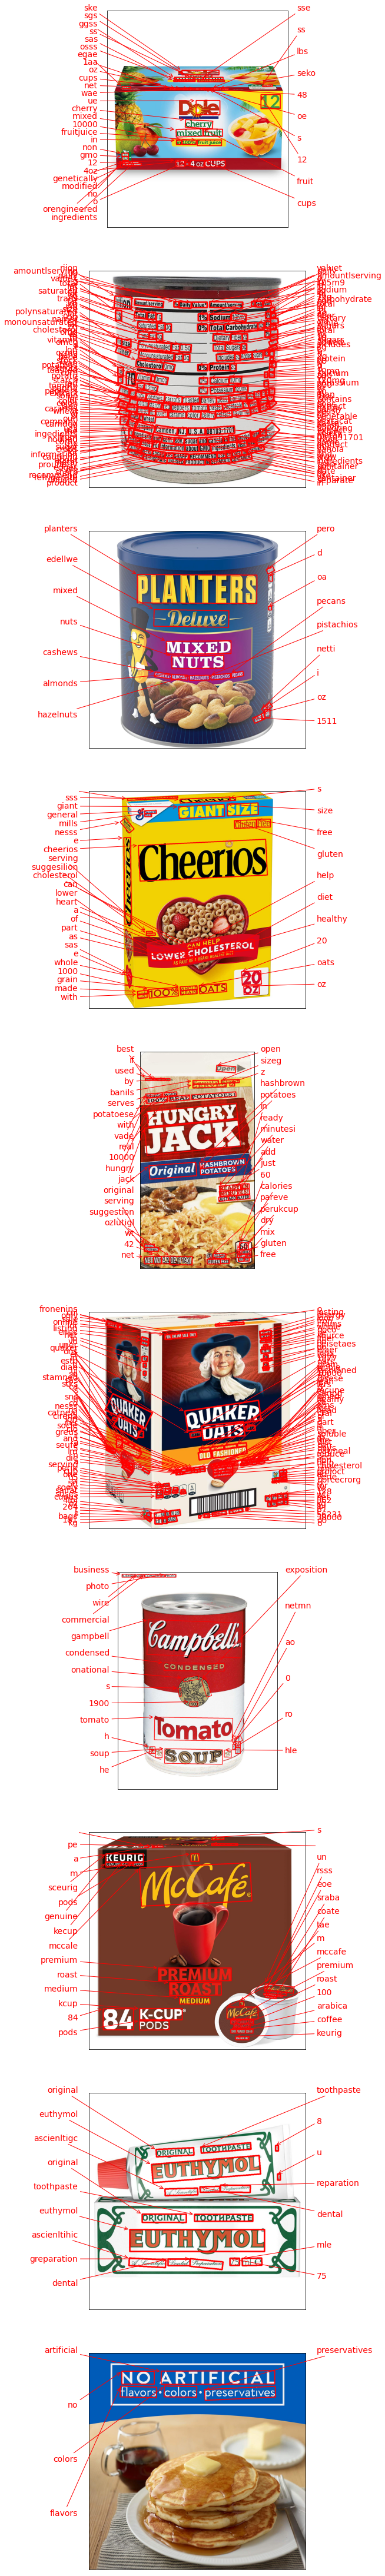

In [9]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(40, 80))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### 3) Tesseract

In [24]:
def recognize_images(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")

            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1

    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [25]:
save_dir = os.getenv('HOME')+'/aiffel/ocr_python/tesseract_cropped'

for file in file_list:
    print(f'[{file}]')
    try:
        recognize_images(os.path.join(img_dir, file), save_dir)
    except:
        print(f'Cannot recognize characters from {file}')

[fruits.jpg]
mixed

fruit

Ath

GM

‘i

eae

4

-407

CUPS

3

Done
[soup02.jpg]

ition

Amount/serving

%/

Daily

Value”

Amount/serving

% Daily

Valye"

>


Potro. z xsea (i Dr ensiman SE ae

i

Total

Fat

1g

1%

Sodium

105md


———_Trans

Fal

0


i

1h

“size


Pojunsaturated Fat 0.5q

Total Sugars Se Cinare bs


ue

0


Nolestaro}

Jm¢

‘\

a\(-

L

]


Jmeg

0%

Protein

2g



()%

Calcium

10mg


)\%

Potassium

120mg

than


:

Dotat

S

latoes

Carrots,

toasted

parley,

DEdS,

ona se

Hy"

Mika ay

He

ah

re

VEDDETS,

romato

paste,

vegeld

a

™

WU,

yf

\|

ee

OT Wheat

Of,

Carame|

COOL

-celer

y extract,

flavoring

Nil

: <


me

th

rt (he

ast DBR ctanp

tye

Ny


I


ty

He ing

nee

amden,

NJ.

) S.A.

08103-1701

quct com

od


it

i.

mn

LOrn,

SOY,

ST

and

eanol

ain this

ie

wats!

aR

AUTON: y

oe

5. Fo

informati

## Step3. 테스트 결과 정리

In [26]:
def compare_ocr(file):
    
    print('\n[Google OCR]')
    detect_text(os.path.join(img_dir, file))
    print('-------------------------------------------')
    
    print('[keras-ocr]')
    idx = file_list.index(file)
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0])
    plt.show()
    print('-------------------------------------------')
    
    print('\n[Tesseract]')
    recognize_images(os.path.join(img_dir, file), save_dir)

### 1) 글자가 빽빽하게 채워져 있는 이미지


[Google OCR]
Texts:

"The ingredients from corn, soy, sugar and canola in this product come fram gandie
dets Bef stock, potatoes, carrots, toasted barley, peas, Contains less than 2% f su
npel Soup Company, Camden, NJ, U.S.A. 08103-1701
modified crops. For information about GMO ingredients, visit: www.Wihatsinlyfsud
id porika extract for color, caramel color, celery extract, flavoring, onion extrad, pai
e Wans, com, potato starch, red peppers, tomato paste, vegetable oil, yeast extrat, ce
CAUTION: METAL EDGES ARE SHARP. RECOMMEND USE BY DATE ON CONTAINER.
PROMPTLY REFRIGERATE UNUSED PRODUCT IN SEPARATE CONTAINER.
nition Amount/serving
% Daily Value
% Daily Value* Amount/serving
Total Fat 1g
Saturated Fat Og
Trans Fat 0g
1% Sodium 105mg
0% Total Carbohydrate 14g 5%
Dietary Fiber 2g
Total Sugars 59
Includes 3g Added Sugars 6%
7% ntet
enpr
ng size Polyunsaturated Fat 0.5g
Monounsaturated Fat Og
ntainer
200
Cholesterol Omg
0% Protein 2g
70 Vitamin D Omcg
Iron 0.2mg
0% Calcium 10mg
0% Pota

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


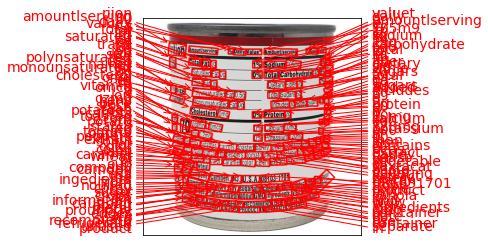

-------------------------------------------

[Tesseract]

ition

Amount/serving

%/

Daily

Value”

Amount/serving

% Daily

Valye"

>


Potro. z xsea (i Dr ensiman SE ae

i

Total

Fat

1g

1%

Sodium

105md


———_Trans

Fal

0


i

1h

“size


Pojunsaturated Fat 0.5q

Total Sugars Se Cinare bs


ue

0


Nolestaro}

Jm¢

‘\

a\(-

L

]


Jmeg

0%

Protein

2g



()%

Calcium

10mg


)\%

Potassium

120mg

than


:

Dotat

S

latoes

Carrots,

toasted

parley,

DEdS,

ona se

Hy"

Mika ay

He

ah

re

VEDDETS,

romato

paste,

vegeld

a

™

WU,

yf

\|

ee

OT Wheat

Of,

Carame|

COOL

-celer

y extract,

flavoring

Nil

: <


me

th

rt (he

ast DBR ctanp

tye

Ny


I


ty

He ing

nee

amden,

NJ.

) S.A.

08103-1701

quct com

od


it

i.

mn

LOrn,

SOY,

ST

and

eanol

ain this

ie

wats!

aR

AUTON: y

oe

5. Fo

informatior

anout

GMO

ingredien|

fe

In [27]:
compare_ocr('soup02.jpg')

### 2) 폰트가 비교적 다양한 이미지


[Google OCR]
Texts:

"Open
BEST IF USED BY A
Family Size!
SERV ES 7
Made vwith
100% REAL POTATOES!
HUNGRY
JACK
Original
HASHBROWN
POTATOES
READY IN
MINUTES!
JUST ADD WATER
SERVING
SUGGESTION
60
NET WIT 4.20Z (19)
O PAREVE
GLUTEN FREE
CALORIES
PER 3CUP
DRY MIX
"

"Open"

"BEST"

"IF"

"USED"

"BY"

"A"

"Family"

"Size!"

"SERV"

"ES"

"7"

"Made"

"vwith"

"100%"

"REAL"

"POTATOES!"

"HUNGRY"

"JACK"

"Original"

"HASHBROWN"

"POTATOES"

"READY"

"IN"

"MINUTES!"

"JUST"

"ADD"

"WATER"

"SERVING"

"SUGGESTION"

"60"

"NET"

"WIT"

"4.20Z"

"(19)"

"O"

"PAREVE"

"GLUTEN"

"FREE"

"CALORIES"

"PER"

"3CUP"

"DRY"

"MIX"
bounds: (718,1429),(747,1429),(747,1448),(718,1448)
-------------------------------------------
[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


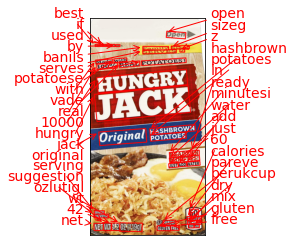

-------------------------------------------

[Tesseract]
ots fT

i

.J3*F ft)

may



1th

100°

o REAL

POTATOES:

ea es in OTA oy }

bi fLS SS


es Eh

,

zm lb

Arai agmiet

ee

TEL

TT

seca

OES

Was “ed

.

PERT4CUP

=

DRY MIX

,


|

i

> gates al ee. a ae a

. S200

a

4

S

cma

a

"3

ANAT) =

Done


In [28]:
compare_ocr('hashbrown.jpg')


[Google OCR]
Texts:

"ORIGINAL TOOTHPASTE
EUTHYMOL
A Scientifio Dental Preparation
ORIGINAL TOOTHPASTE
EUTHYMOL
A Scientifio Dental Preparation 75 ml E
LOT
EXP
"

"ORIGINAL"

"TOOTHPASTE"

"EUTHYMOL"

"A"

"Scientifio"

"Dental"

"Preparation"

"ORIGINAL"

"TOOTHPASTE"

"EUTHYMOL"

"A"

"Scientifio"

"Dental"

"Preparation"

"75"

"ml"

"E"

"LOT"

"EXP"
bounds: (879,378),(880,402),(871,402),(870,378)
-------------------------------------------
[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


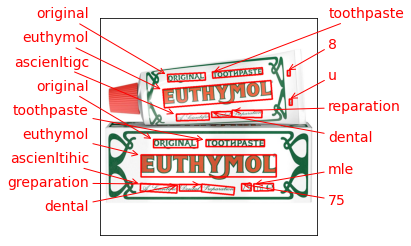

-------------------------------------------

[Tesseract]

N\

—_ LIF one

Ea *

ORIGINAL.

TOOTHPASTE

EUTHYMOL

Ge

 Secentifec

Dpertial


A

= ne Eicon cla WN

——I~Y |

ORIGINAL

TOOTUPASTE

EUTHYMOL

oS


Yo ntil

Trcparation

Ths

m|

(>

K EUTHYS i I :

Done


In [29]:
compare_ocr('toothpaste.jpg')

### 3) 기울어진 이미지


[Google OCR]
Texts:

"NMO
FIROLUME SAE ONICE
LASTING
ENERGY
FROM 100%
WHOLE GRAINS
FOR ONLINE SALE ONLY
LASTIMG
EMERCY
Co0
SOURCE OF
FIBER
...
FIBER
NO
PRESERVITIVES*
NO
NO
ARTIFICIAL
QUAKER
OATS
QUAKER
ОATS
EST
1877
1877
EST?
OLD FASHIONED
100% WHOLE GRAIN OATS
OLD FASHIONED
may help reduce the risk of heart diseate
This cereal has 2 prams per serving.
CHAESTENS
3 grams of soluble tiber from aatmeal daily in
a diet low in saturated fat and cholesterol
OATMEAL CAN
HELP REDUCE
CHOLESTEROL
e soluble fiber in
Elle
Project
VERIFIED
nangmeprojact.org
per iz cup serving
Ong
4
FIBER
05
TOTAL
SUGARS
150
CALORMS
SATFAT
KOV
NET WT 128 OZ
(8 LB) 3.62 kg
2- 64 OZ (4 LB)
1.81 kg BAGS
O 00 30000 56231 4
"

"NMO"

"FIROLUME"

"SAE"

"ONICE"

"LASTING"

"ENERGY"

"FROM"

"100%"

"WHOLE"

"GRAINS"

"FOR"

"ONLINE"

"SALE"

"ONLY"

"LASTIMG"

"EMERCY"

"Co0"

"SOURCE"

"OF"

"FIBER"

"..."

"FIBER"

"NO"

"PRESERVITIVES*"

"NO"

"NO"

"ARTIFICIAL"

"QUAKER"

"OATS"

"QUAKER"

"ОATS"

"EST"

"1877"

"18

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


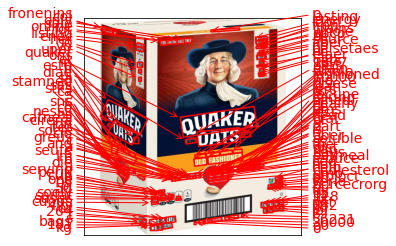

-------------------------------------------

[Tesseract]
NET WI

(78 OZ

(8 LB)

762 Kg


Done


In [30]:
compare_ocr('oats.jpg')

## Step4. 결과 분석과 결론 제시

### Google OCR API
가장 인식률이 좋았고, 다른 API들은 글자 단어 단위로 인식을 하는데 비해서, 단어가 연결되어 인식을 하는 것을 알 수 있어서 가장 글자 자체는 가장 편리하게 인식이 가능했다.
### keras-ocr
인식은 Google OCR API에 비해 글자의 인식률은 낮은 편이지만, 그래도 어느 정도 잘 인식을 하는 편이었다. 사진에 글자가 바로 표시되어 인식을 하는 데 있어서 도움이 많이 되었다.

### Tesseract
인식률이 다른 API에 비해 현저히 낮았고, 다른 API는 글자가 틀리더라도 인식을 하는 편인데, 아예 글자 자체를 인식하지 못 하는 경우가 많았다.

### 결론
Google OCR API, keras-ocr 모두 사용하기 편리한 기능이 달라서, 둘을 적절히 잘 사용하면 더 글자를 인식하는 데에 좋은 성과를 얻을 수 있을 것으로 보인다.

## Rubric

||**평가 문항**|**상세 기준**|
|:--------|:--------|:--------|
|**1**|OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?|목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.|
|**2**|모델 평가기준이 명확하고 체계적으로 세워졌는가?|평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.|
|**3**|평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?|최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.|

## 회고

#### 느낀 점

역시 구글이 제일 똑똑하다. 하지만 내 소중한 클라우드 플랫폼의 무료 사용 기회를 이렇게 써먹는 게 좀 아까웠다.

잘 만들어진 API들을 사용하면서, 그나마 잘 인식이 안되는 Tesseract라도 내가 만들면 저렇게나마 만들 수 없을 거라고 생각이 들어, 인식이 안된다고 무시할 마음이 들지 않는다.